In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Polimi/Exercise_5/Notebooks

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Polimi/Exercise_5/Notebooks


### Import libraries


In [ ]:
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
tfk = tf.keras
tfkl = tf.keras.layers

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()
# Pad the model with zeros
X_train = np.pad(X_train, ((0,0),(2,2),(2,2)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2)), 'constant')

11501568/11490434 [==============================] - 0s 0us/step


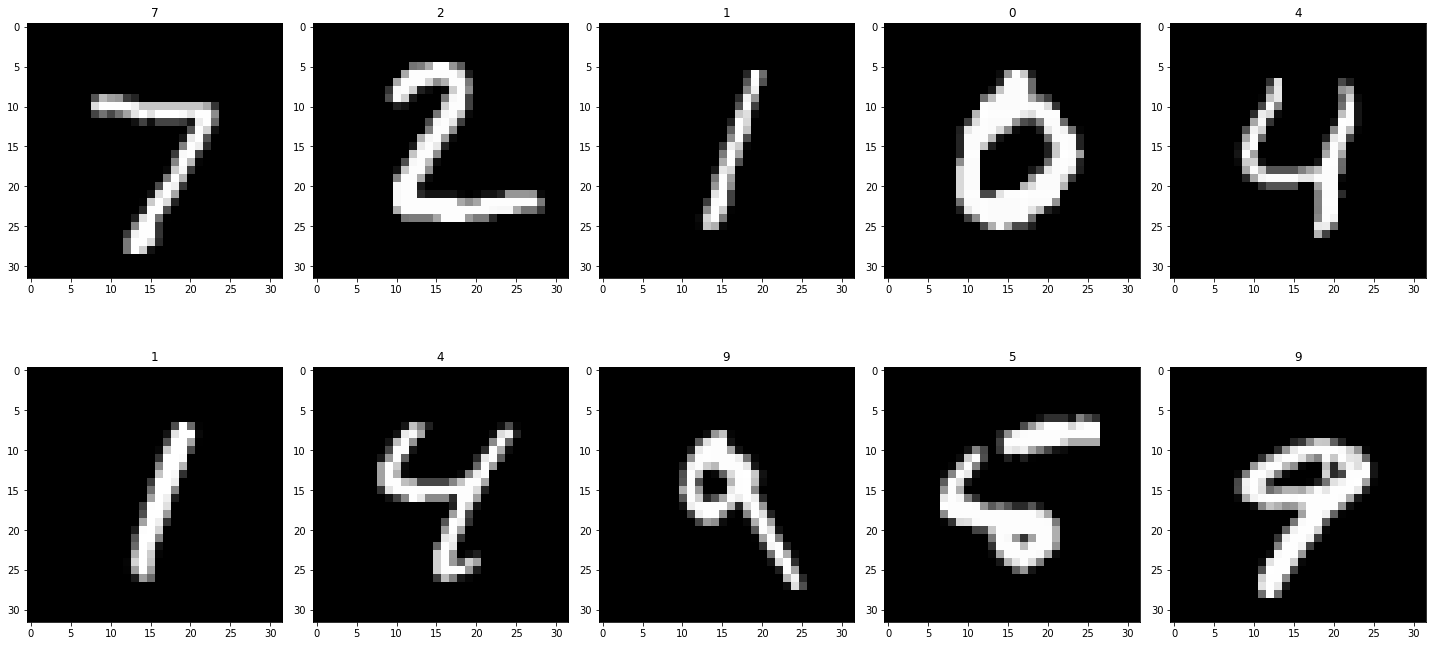

In [ ]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title('{}'.format(y_test[i]))
plt.tight_layout()
plt.show()

In [ ]:
X_train = np.expand_dims(X_train, -1).astype("float16") / 255
X_test = np.expand_dims(X_test, -1).astype("float16") / 255

classes = np.unique(y_test)
n_classes = len(classes)
latent_dim = 2
input_shape = X_train.shape[1:]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print("Classes:",classes)

X_train shape (60000, 32, 32, 1)
y_train shape (60000,)
X_test shape (10000, 32, 32, 1)
y_test shape (10000,)
Classes: [0 1 2 3 4 5 6 7 8 9]


Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 Encoder (Sequential)        (None, 2)                 130114    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d (Conv2D)           (None, 32, 32, 16)        160       |
|                                                               |
| max_pooling2d (MaxPooling2D  (None, 16, 16, 16)     0         |
| )                                                             |
|                                                               |
| conv2d_1 (Conv2D)         (None, 16, 16, 32)        4640      |
|                                                               |
| max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)       0         |
| 2D)                                                  

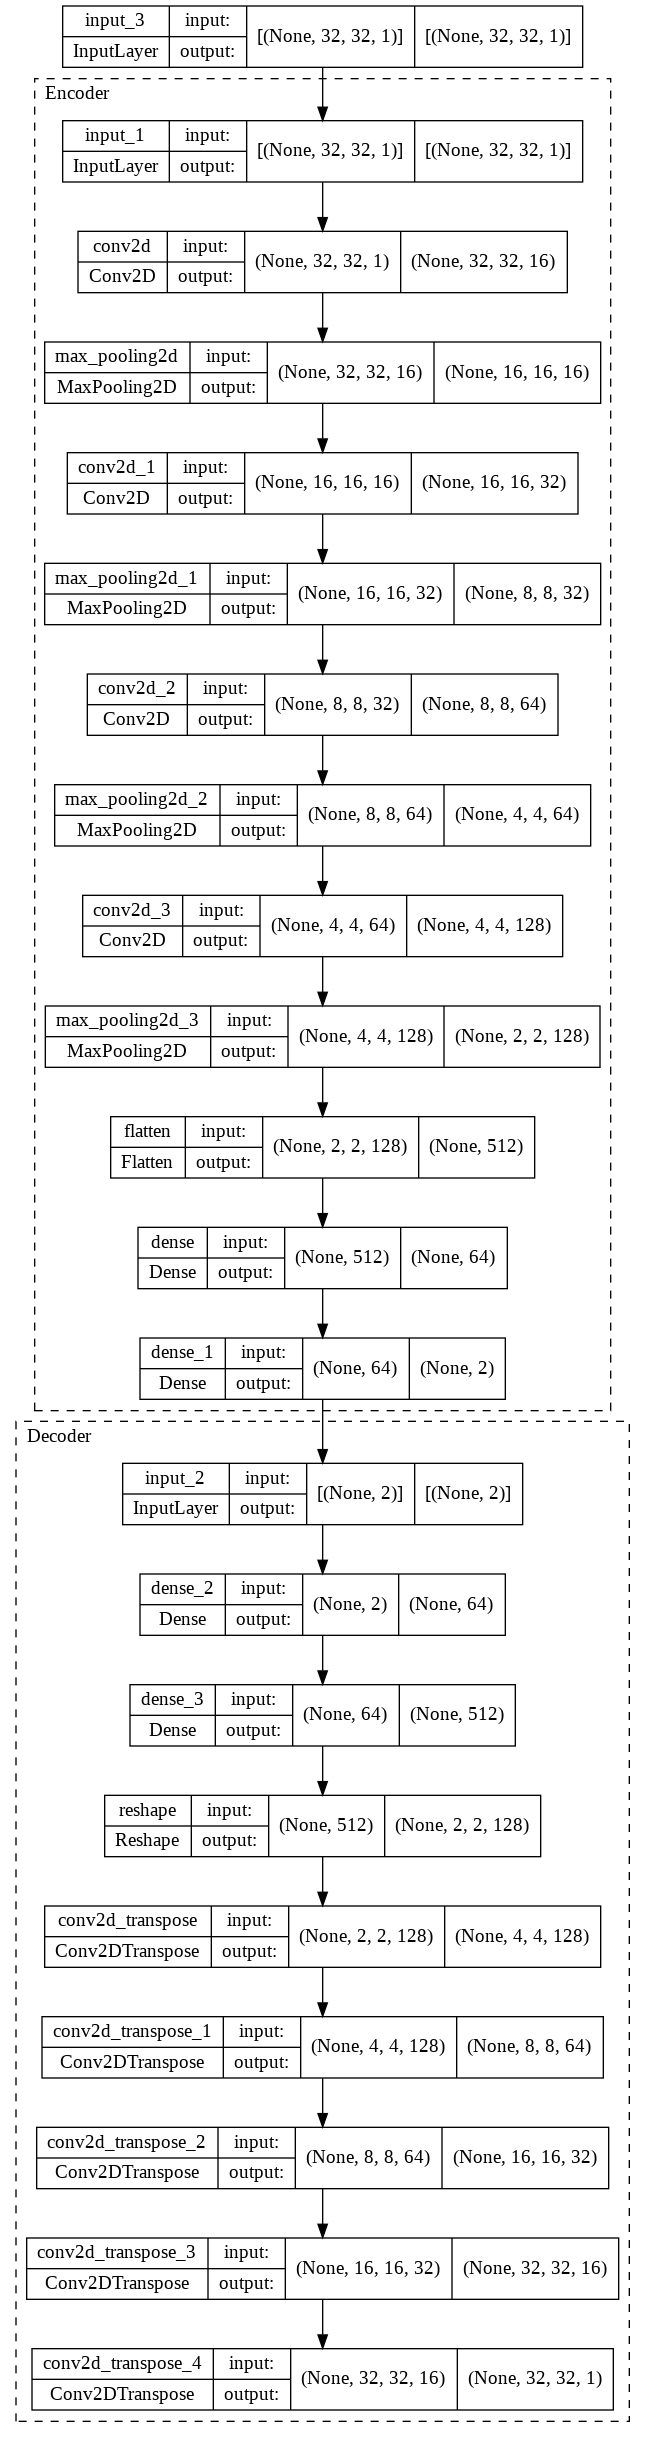

In [ ]:
def build_model(input_shape, latent_dim, verbose=True):

    encoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=(input_shape)),
        tfkl.Conv2D(16, 3, (1, 1), padding='same', activation='relu'),
        tfkl.MaxPooling2D(),
        tfkl.Conv2D(32, 3, (1, 1), padding='same', activation='relu'),
        tfkl.MaxPooling2D(),
        tfkl.Conv2D(64, 3, (1, 1), padding='same', activation='relu'),
        tfkl.MaxPooling2D(),
        tfkl.Conv2D(128, 3, (1, 1), padding='same', activation='relu'),
        tfkl.MaxPooling2D(),
        tfkl.Flatten(),
        tfkl.Dense(64, activation='relu'),
        tfkl.Dense(latent_dim, activation='linear')
    ], name='Encoder')

    decoder = tfk.Sequential([
        tfkl.InputLayer(input_shape=(latent_dim)),
        tfkl.Dense(64, activation='relu'),
        tfkl.Dense(512,activation='relu'),
        tfkl.Reshape((2,2,128)),
        tfkl.Conv2DTranspose(128, 3, (2,2), padding='same', activation='relu'),
        tfkl.Conv2DTranspose(64, 3, (2,2), padding='same', activation='relu'),
        tfkl.Conv2DTranspose(32, 3, (2,2), padding='same', activation='relu'),
        tfkl.Conv2DTranspose(16, 3, (2,2), padding='same', activation='relu'),
        tfkl.Conv2DTranspose(1, (1,1), padding='same', activation='sigmoid'),
    ], name='Decoder')

    ae_input = tfk.Input(shape=input_shape)
    z = encoder(ae_input) #latent rep.
    autoencoder = tfk.Model(inputs=ae_input, outputs=decoder(z), name='Autoencoder')

    autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=tfk.losses.binary_crossentropy, metrics=['mse', 'mae'])
    if(verbose):
        autoencoder.summary(expand_nested=True)
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = build_model(input_shape,latent_dim)
tfk.utils.plot_model(autoencoder, show_shapes=True, expand_nested=True)

In [ ]:
history = autoencoder.fit(
    X_train,
    X_train,
    batch_size=256,
    epochs=1000,
    validation_split=.1,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    ]
).history

Epoch 1/1000
211/211 [==============================] - 22s 46ms/step - loss: 0.2340 - mse: 0.0621 - mae: 0.1378 - val_loss: 0.1823 - val_mse: 0.0459 - val_mae: 0.1026 - lr: 0.0010
Epoch 2/1000
211/211 [==============================] - 9s 41ms/step - loss: 0.1758 - mse: 0.0437 - mae: 0.0990 - val_loss: 0.1697 - val_mse: 0.0417 - val_mae: 0.0935 - lr: 0.0010
Epoch 3/1000
211/211 [==============================] - 9s 41ms/step - loss: 0.1646 - mse: 0.0401 - mae: 0.0918 - val_loss: 0.1590 - val_mse: 0.0382 - val_mae: 0.0872 - lr: 0.0010
Epoch 4/1000
211/211 [==============================] - 9s 41ms/step - loss: 0.1564 - mse: 0.0374 - mae: 0.0863 - val_loss: 0.1524 - val_mse: 0.0359 - val_mae: 0.0836 - lr: 0.0010
Epoch 5/1000
211/211 [==============================] - 9s 41ms/step - loss: 0.1523 - mse: 0.0360 - mae: 0.0834 - val_loss: 0.1496 - val_mse: 0.0349 - val_mae: 0.0816 - lr: 0.0010
Epoch 6/1000
211/211 [==============================] - 9s 41ms/step - loss: 0.1492 - mse: 0.0348 -

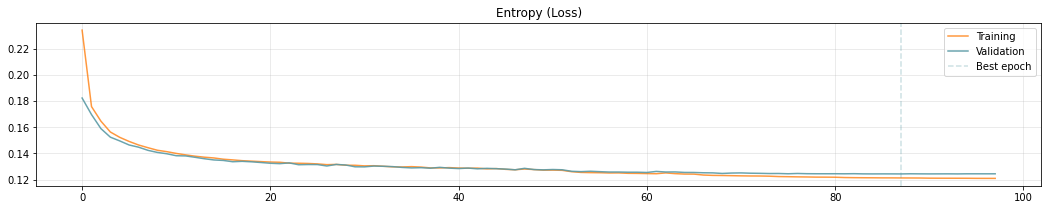

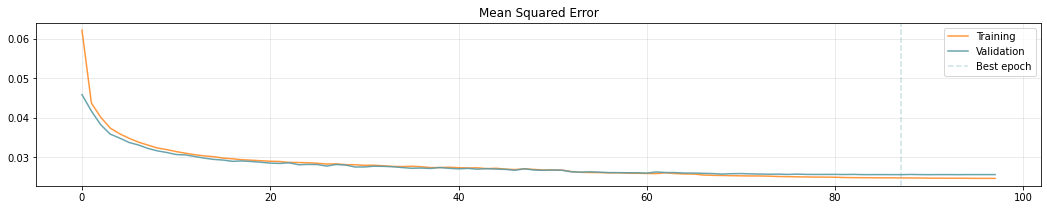

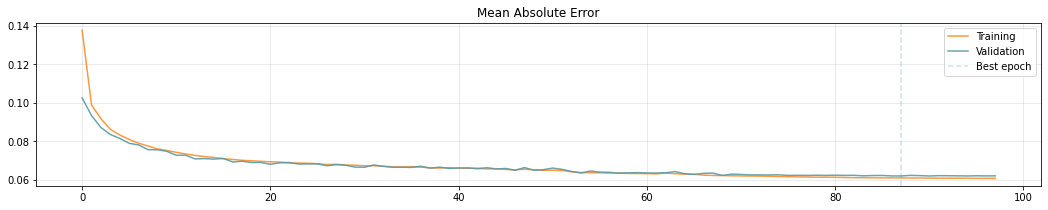

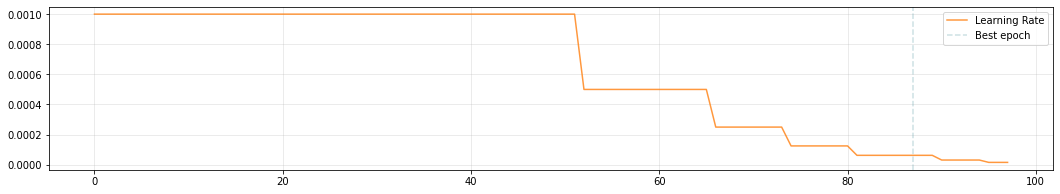

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mse'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mse'], label='Validation', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['mae'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Below to save the model after training

In [ ]:
# autoencoder.save('autoencoder')

Load the autoencoder

In [ ]:
autoencoder = tfk.models.load_model('autoencoder')
encoder = autoencoder.get_layer('Encoder')
decoder = autoencoder.get_layer('Decoder')

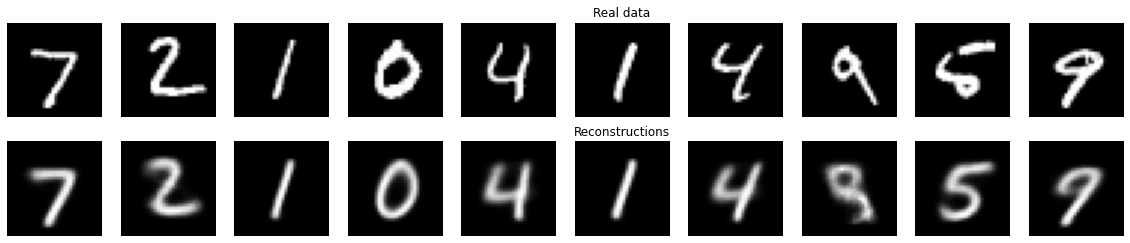

In [ ]:
predictions = autoencoder.predict(X_test)
imgs = 10
fig, axs = plt.subplots(2, imgs, figsize=(imgs*2, 4), clear=True)
for i in range(imgs):
    axs[0, i].imshow(np.reshape(X_test[i], (32,32)).astype('float32'), cmap=plt.get_cmap('gray'))
    axs.flat[i].axis('off')
    axs[1, i].imshow(np.reshape(predictions[i], (32,32)).astype('float32'), cmap=plt.get_cmap('gray'))
    axs.flat[i+imgs].axis('off')
axs[0,imgs//2].set_title('Real data')
axs[1,imgs//2].set_title('Reconstructions')
plt.show()

In [ ]:
entropy_score = np.mean(tfk.losses.binary_crossentropy(X_test, predictions))
mse_score = np.mean(tfk.losses.mean_squared_error(X_test, predictions))
mae_score = np.mean(tfk.losses.mean_absolute_error(X_test, predictions))
print('Entropy:',entropy_score)
print('MSE:',mse_score)
print('MAE:',mae_score)

Entropy: 0.1255992
MSE: 0.02621156
MAE: 0.06286785


Project the training set into the latent space

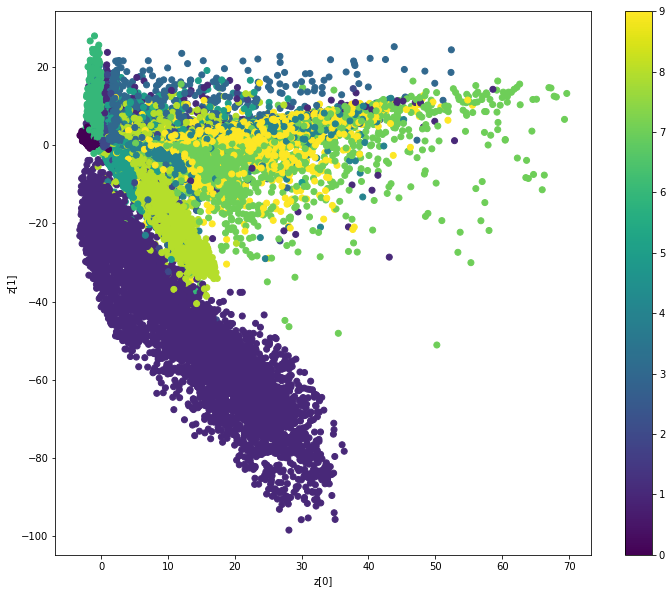

In [ ]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, X_train, y_train)

Plot uniform samples from the latent space

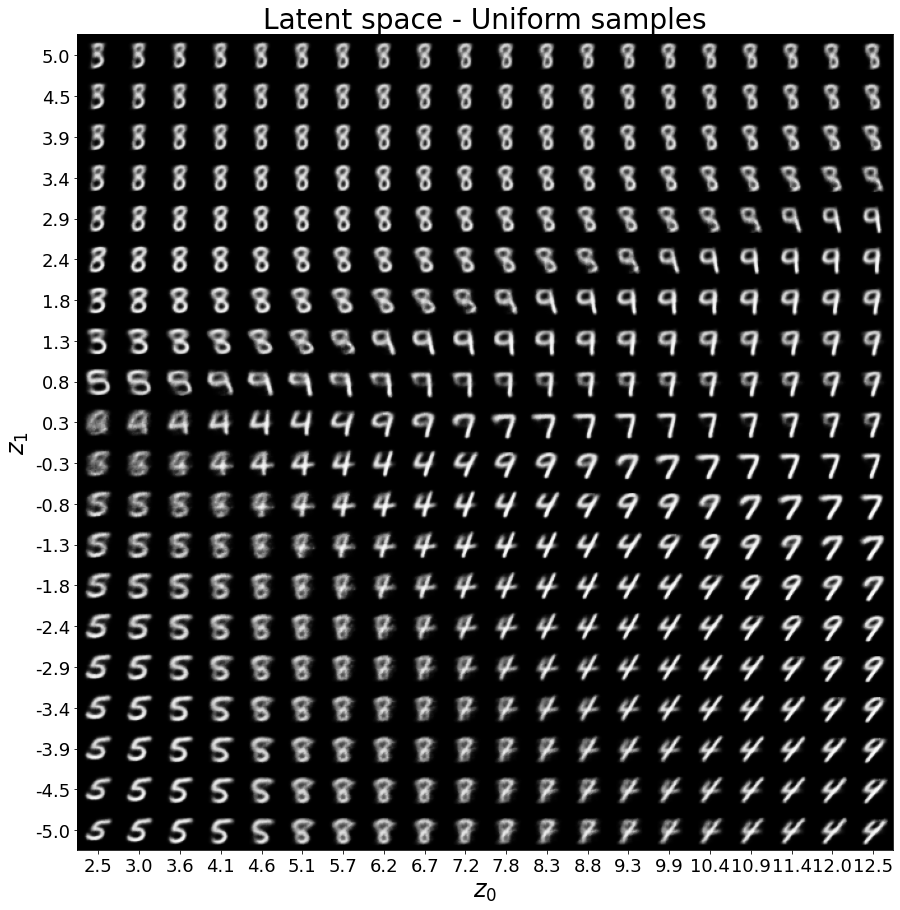

In [ ]:
def plot_latent_space(decoder, x_lim, y_lim, n_per_dim=20, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n_per_dim, digit_size * n_per_dim))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(x_lim[0], x_lim[1], n_per_dim)
    grid_y = np.linspace(y_lim[0], y_lim[1], n_per_dim)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # z_sample = np.array([[xi, yi]])
            z_sample = np.reshape(np.linspace(xi, yi, latent_dim), (1, latent_dim))
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n_per_dim * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel(r'$z_0$', fontsize=24)
    plt.ylabel(r'$z_1$', fontsize=24)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Latent space - Uniform samples', fontsize=28)
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(decoder, x_lim=(2.5,12.5), y_lim=(-5,5), n_per_dim=20, digit_size=32)